###  MicroGrad demo

In [40]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torch


from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
from micrograd.onehot import arr2vals, oh_encode
from micrograd.eval import evaluate, calc_accuracy, calc_sq_loss
from micrograd.visualize import draw_dot

%matplotlib inline

In [41]:
np.random.seed(1337)
random.seed(1337)

# Get MNIST dataset

In [42]:
from torchvision import datasets as dts

MNIST_DATASET = dts.MNIST(root = 'data', train = True, download=True)

X_train_orig = MNIST_DATASET.data / 255.0 # * 2 - 1
X_train = X_train_orig.reshape(X_train_orig.shape[0], 784)

Y_train = MNIST_DATASET.targets

In [43]:
ALL_POSITIVE_CLASSES = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

enc, dec = oh_encode(ALL_POSITIVE_CLASSES)
enc(ALL_POSITIVE_CLASSES)

tensor([[ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.]])

In [44]:
import torch


def append_noise(X, noise_size, min=-1.0, max=1.0):
    noise_shape = torch.Size([noise_size]) + X.shape[1:]
    noise_tensor = torch.empty(noise_shape).uniform_(min, max)
    return torch.concat([X, noise_tensor])


def append_void(X, void_size, void=-1.0):
    void_shape = torch.Size([void_size]) + X.shape[1:]
    void_tensor = torch.empty(void_shape).fill_(void)
    return torch.concat([X, void_tensor])


def get_batch(X, Y, batch_size, noise_ratio=0.0, void_ratio=0.0, void_class=-1):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y = X[ri], Y[ri]

    if noise_ratio > 0.0:
        noise_size = round(batch_size * noise_ratio)
        X = append_noise(X, noise_size)
        Y = torch.concat([Y, torch.tensor([void_class] * noise_size)])

    if void_ratio > 0.0:
        void_size = round(batch_size * void_ratio)
        X = append_void(X, void_size, void=np.random.uniform(0, 1))
        Y = torch.concat([Y, torch.tensor([void_class] * void_size)])

    return X, Y


def batch2vals(batch):
    return tuple(map(arr2vals, batch))


# save/load

In [45]:
POSITIVE_NEURONS = 'mnist_parameters_10x785_positives.npy'


def save_neurons(file, neurons):
    weights = np.array([[p.data for p in n.parameters()] for n in neurons])
    np.save(file, weights)


def load_neurons(file):
    weights = np.load(file)
    neurons = [Neuron(nin=weights.shape[1] - 1, act='sbin') for _ in range(weights.shape[0])]
    for Wi in range(len(neurons)):
        for p, w in zip(neurons[Wi].parameters(), weights[Wi]):
            p.data = w
            p._lr = 0.0
    return neurons

In [46]:
import matplotlib.pyplot as plt


def select(X, Y, selector):
    idx = np.where(np.isin(Y, selector))[0]
    return X[idx], Y[idx]


def select_batch(X, Y, selector, batch_size, noise_ratio=0.0, void_ratio=0.0, void_class=torch.nan):
    idx = np.where(np.isin(Y, selector))[0]
    return get_batch(X[idx], Y[idx], batch_size, noise_ratio, void_ratio, void_class)


def draw_neuron(model, neuron, layer=0):
    w = np.array([p.data for p in model.layers[layer].neurons[neuron].parameters()][:-1])
    w = w.reshape([-1, w.shape[0]])
    plt.imshow(w)


def one_neuron_histo(neuron, bins=100):
    array = np.array([p.data for p in neuron.parameters()])
    plt.hist(array, bins=bins, edgecolor='black')

    plt.title('Гистограмма нейрона')
    plt.xlabel('Вес')
    plt.ylabel('Частота')

    plt.show()


def draw_all_neurons(neurons, key=lambda p: p.data,):
    fig, axes = plt.subplots(1, len(neurons), sharey=True)
    if len(neurons) == 1:
        axes = [axes]

    for neuron, axe in zip(neurons, axes):
        array = np.array([key(p) for p in neuron.parameters()][:28**2])
        array = array.reshape([-1, array.shape[0]])
        axe.imshow(array.reshape([28, 28]))
    fig.suptitle("Нейроны")


def all_neurons_histo(neurons, key=lambda p: p.data, bins=100):
    fig, axes = plt.subplots(1, len(neurons), sharey=True)
    if len(neurons) == 1:
        axes = [axes]

    for neuron, axe in zip(neurons, axes):
        array = np.array([key(p) for p in neuron.parameters()])
        axe.hist(array, bins=bins, edgecolor='black')

    fig.suptitle('Гистограмма нейронов')
    fig.supxlabel('Вес')
    fig.supylabel('Частота')

    plt.show()

In [47]:
import functools

SELECTED_CLASSES = [0, 1]
OUT_DIM = len(SELECTED_CLASSES)
OH_ENC, OH_DEC = oh_encode(SELECTED_CLASSES)

NOISE_RATIO = 0.0
VOID_RATIO = 0.0
ITERATIONS = 1
BATCH_SIZE = 10
BATCH = select_batch(X_train, Y_train, SELECTED_CLASSES, BATCH_SIZE, noise_ratio=NOISE_RATIO, void_ratio=VOID_RATIO)
X_b, Y_b = BATCH

X = arr2vals(X_b, 'input')
Y_oh = arr2vals(OH_ENC(Y_b), 'target')

# learning rate is inversely proportional to the samples number due to the nature of the loss function
# the loss function sums up all scores so the resulting gradient is the sum of all sample gradients
# that is why
LEARNING_RATE = 1.0 / len(X)
ESAT = 1e-9

MODEL = MLP(
    [
        Layer('sbin', _lid=0, init=lambda: 0, LR=LEARNING_RATE),
        Layer('sbin', _nout=OUT_DIM, _lid=1, init=lambda: random.choice([-1, 1]), LR=LEARNING_RATE)
    ],
    train=True
)

get_loss = functools.partial(calc_sq_loss, targets=Y_oh)
LEARNER, scores, loss = MODEL.make_learner(X, get_loss=get_loss, ESAT=ESAT)

0 loss: 20.0
EARLY STOP BY ESAT=1e-09!
final loss: 0.0
accuracy = 1.0:
[(Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [1.0, 0.0, 1.0])), (Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [1.0, 0.0, 1.0])), (Value(sbin : [1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])), (Value(sbin : [1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])), (Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [1.0, 0.0, 1.0])), (Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [1.0, 0.0, 1.0])), (Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [1.0, 0.0, 1.0])), (Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [1.0, 0.0, 1.0])), (Value(sbin : [1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])), (Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [1.0, 0.0, 1.0]))]


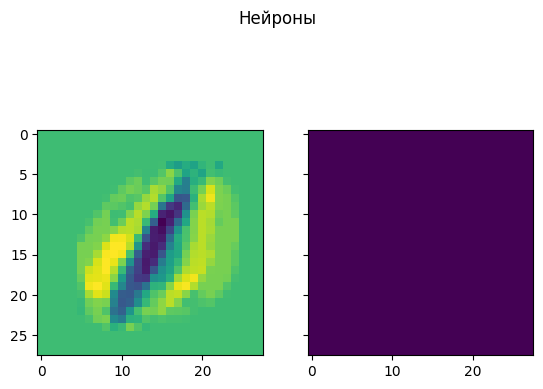

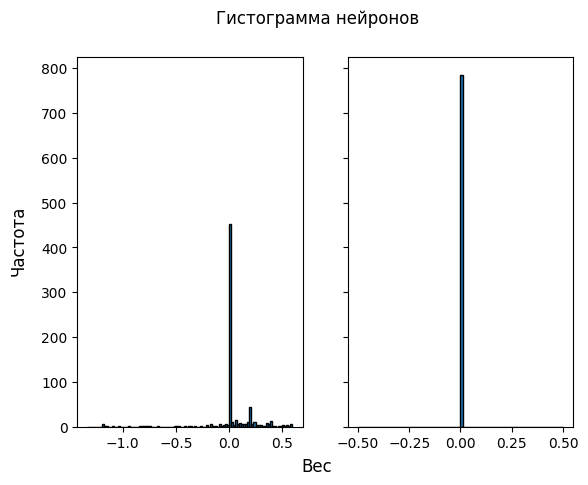

In [48]:
total_loss, scores = LEARNER(i=1, q=1.0)

acc = calc_accuracy(scores, Y_oh, OH_DEC)
print(f'accuracy = {acc}:\n{scores}')

draw_all_neurons(MODEL.layers[0].neurons)
all_neurons_histo(MODEL.layers[0].neurons)

# DEBUG

In [37]:
MODEL.layers[0].expandable=False

0 loss: 0.0
1 loss: 14.0
2 loss: 6.0
3 loss: 6.0
4 loss: 2.0
5 loss: 4.0
6 loss: 12.0
7 loss: 6.0
8 loss: 8.0
9 loss: 4.0
final loss: 14.0
accuracy = 0.3:
[(Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])), (Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])), (Value(sbin : [1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])), (Value(sbin : [1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])), (Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])), (Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])), (Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])), (Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])), (Value(sbin : [1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])), (Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0]))]


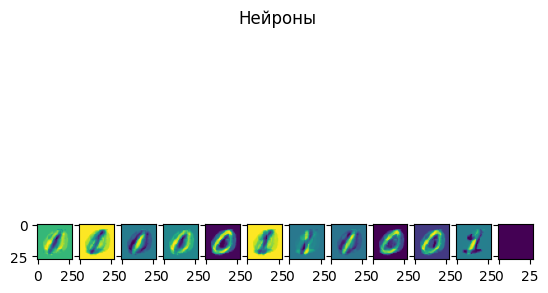

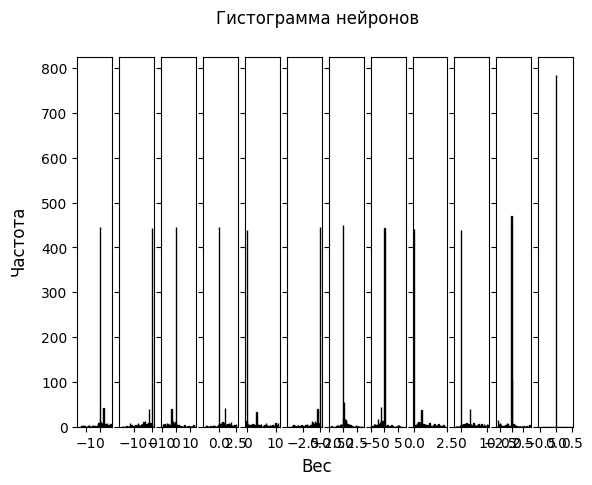

In [49]:
total_loss, scores = LEARNER(i=10, q=1.0)

acc = calc_accuracy(scores, Y_oh, OH_DEC)
print(f'accuracy = {acc}:\n{scores}')

draw_all_neurons(MODEL.layers[0].neurons)
all_neurons_histo(MODEL.layers[0].neurons)

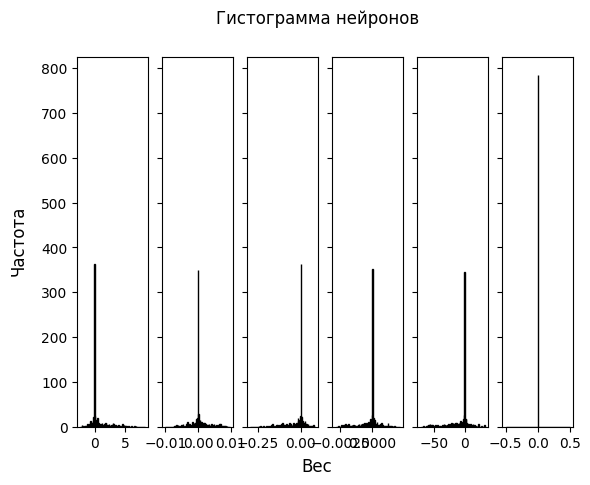

In [15]:
all_neurons_histo(MODEL.layers[0].neurons, key=lambda p: p.grad)

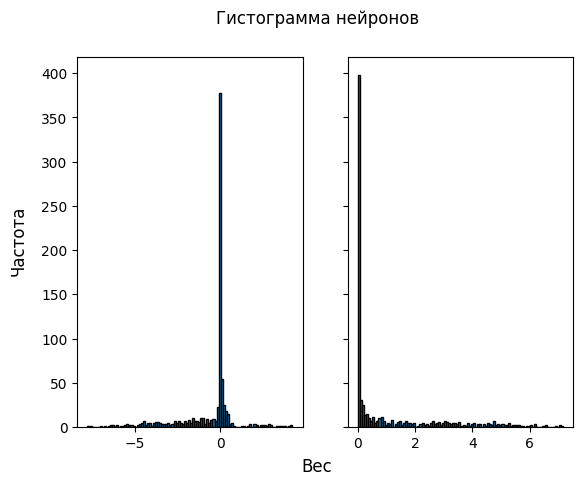

In [26]:
total_loss.backward()
all_neurons_histo(MODEL.layers[0].neurons, key=lambda p: p.grad)

In [148]:
import pandas as pd

data = [p.data for p in MODEL.layers[0].neurons[0].parameters()]
data.sort()

pd.DataFrame(data).describe()

,0
count,784.000000
mean,0.006180
std,0.549604
min,-2.655730
25%,-0.000291
50%,0.000000
75%,0.114699
max,1.856582


In [149]:
data

[-2.655730186995071,
 -2.550704869519407,
 -2.309559145340734,
 -2.2908110238335975,
 -2.230261249447838,
 -1.9838724831180137,
 -1.8177012682410156,
 -1.784513761791935,
 -1.6929082114119138,
 -1.6724952804264626,
 -1.6708250301452758,
 -1.6681502511256812,
 -1.6169151654983418,
 -1.551717873769041,
 -1.5238292434315635,
 -1.455245454607186,
 -1.4313637261808454,
 -1.4246000292642913,
 -1.41666848994968,
 -1.3985466985173771,
 -1.390016069036498,
 -1.3773850075111345,
 -1.3767106947631724,
 -1.3315426171314153,
 -1.3196614758398075,
 -1.3012349612020195,
 -1.282425232471023,
 -1.2566962149755727,
 -1.2394287762500928,
 -1.2355910862434298,
 -1.2163562603055338,
 -1.2111827750790065,
 -1.1938087917059812,
 -1.1753048915370874,
 -1.1372266005542557,
 -1.1135800014476795,
 -1.0685289157282711,
 -1.0682175024390483,
 -1.0363335463439707,
 -1.0270001668590276,
 -1.0245840666630175,
 -1.0149474524030455,
 -0.9841626052681244,
 -0.9805369673231108,
 -0.977951495110162,
 -0.9777175583628851,
